<a href="https://colab.research.google.com/github/Pushpita15/Bike_Sharing_Demand_Project/blob/main/bike_sharing_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict Bike Sharing Demand with AutoGluon Template**

### Installing packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
Using cached setuptools-69.5.1-py3-none-any.whl (894 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.0 MB/s eta 0:00:00
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080016 sha256=94f02df8c4cc898790a203fae4d6f6ad094a9e4c40ad3516ee718b0cef46a520
  Stored in directory: /root/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.8 requires bokeh<3.4.0,

## Step 2: Download the Kaggle dataset using the kaggle python library

### Setup Kaggle API Key

In [ ]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "pdabcd"
kaggle_key = "24e404890acf97148ffdb7e84c5729d5"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 78.8MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


**Exploring the dataset**

In [ ]:
import numpy
import pandas as pd
from datetime import datetime
from autogluon.tabular import TabularPredictor

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train['datetime'] = pd.to_datetime(train['datetime'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test['datetime'] = pd.to_datetime(test['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [ ]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission['datetime'] = pd.to_datetime(submission['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6493 non-null   datetime64[ns]
 1   count     6493 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 101.6 KB


**Step 3 : Training a model using AutoGluon's Tabular prediction**

Requirements:

*    We are prediting count, so it is the label we are setting.
*  Ignore casual and registered columns as they are also not present in the test dataset.

*   Use the root_mean_squared_error as the metric to use for evaluation.
*  Set a time limit of 10 minutes (600 seconds).

*   Use the preset best_quality to focus on creating the best model.







In [ ]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129


In [ ]:
predictor = TabularPredictor(label='count',problem_type='regression',eval_metric='root_mean_squared_error').fit(train,time_limit=600,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_063708"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240424_063708/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 191 seconds

**Review AutoGluon's training run with ranking of models that did the best.**

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   -2.200765  root_mean_squared_error      73.823292  353.073024                0.001310           0.042813            2       True          7
1  RandomForestMSE_BAG_L1   -2.815309  root_mean_squared_error       0.809749   29.562247                0.809749          29.562247            1       True          5
2         LightGBM_BAG_L1   -3.124826  root_mean_squared_error       5.949028   68.657163                5.949028          68.657163            1       True          4
3         CatBoost_BAG_L1   -3.273052  root_mean_squared_error       0.073419   60.243403                0.073419          60.243403            1       True          6
4       LightGBMXT_BAG_L1   -4.209634  root_mean_squared_error      66.989785  194.567398         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -4.209633576322336,
  'LightGBM_BAG_L1': -3.124825813111386,
  'RandomForestMSE_BAG_L1': -2.815309019546902,
  'CatBoost_BAG_L1': -3.2730521630267466,
  'WeightedEnsemble_L2': -2.2007647572776046},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],
  'LightGBMXT_BAG_L1': ['LightGBMXT_BAG_L1'],
  'LightGBM_BAG_L1': ['LightGBM_BAG_L1'],
  'RandomForestMSE_BAG_L1': [

<Axes: xlabel='model'>

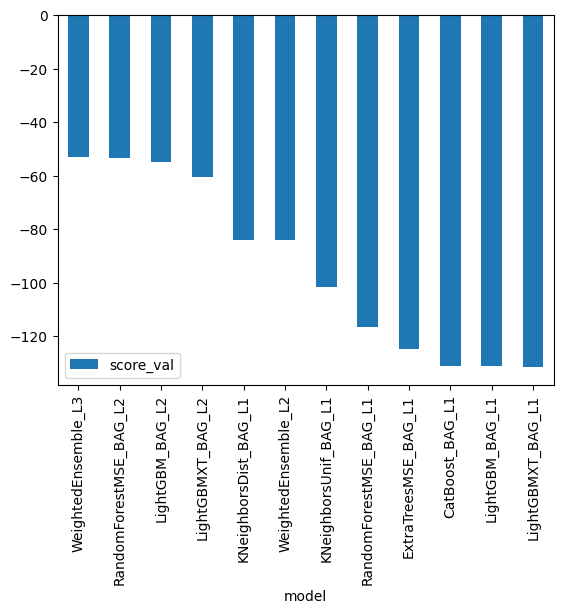

In [ ]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

**Create predictions from test dataset**

In [ ]:
predictions = predictor.predict(test)
predictions.head()

0    23.331345
1    42.712925
2    45.682648
3    49.051163
4    51.951324
Name: count, dtype: float32

In [ ]:
predictions.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6493 entries, 0 to 6492
Series name: count
Non-Null Count  Dtype  
--------------  -----  
6493 non-null   float32
dtypes: float32(1)
memory usage: 25.5 KB


In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.494301
std        89.902916
min         3.063824
25%        19.823523
50%        64.080978
75%       168.007202
max       367.517670
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
negative_count = predictions[predictions < 0 ].count()
print(f"The count of negative values: {negative_count}")

The count of negative values: 0


In [ ]:
# Set them to zero
if(negative_count >= 1):
  predictions[predictions<0]=0
else:
  print("There are no negative values")

There are no negative values


**Set predictions to submission dataframe, save, and submit**

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 355kB/s]  
Successfully submitted to Bike Sharing Demand

**View submission via the command line or in the web browser under the competition's page - My Submissions**

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### Initial score of 1.80546

**Step 4: Exploratory Data Analysis and Creating an additional feature
Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.**

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'count'}>, <Axes: >, <Axes: >]],
      dtype=object)

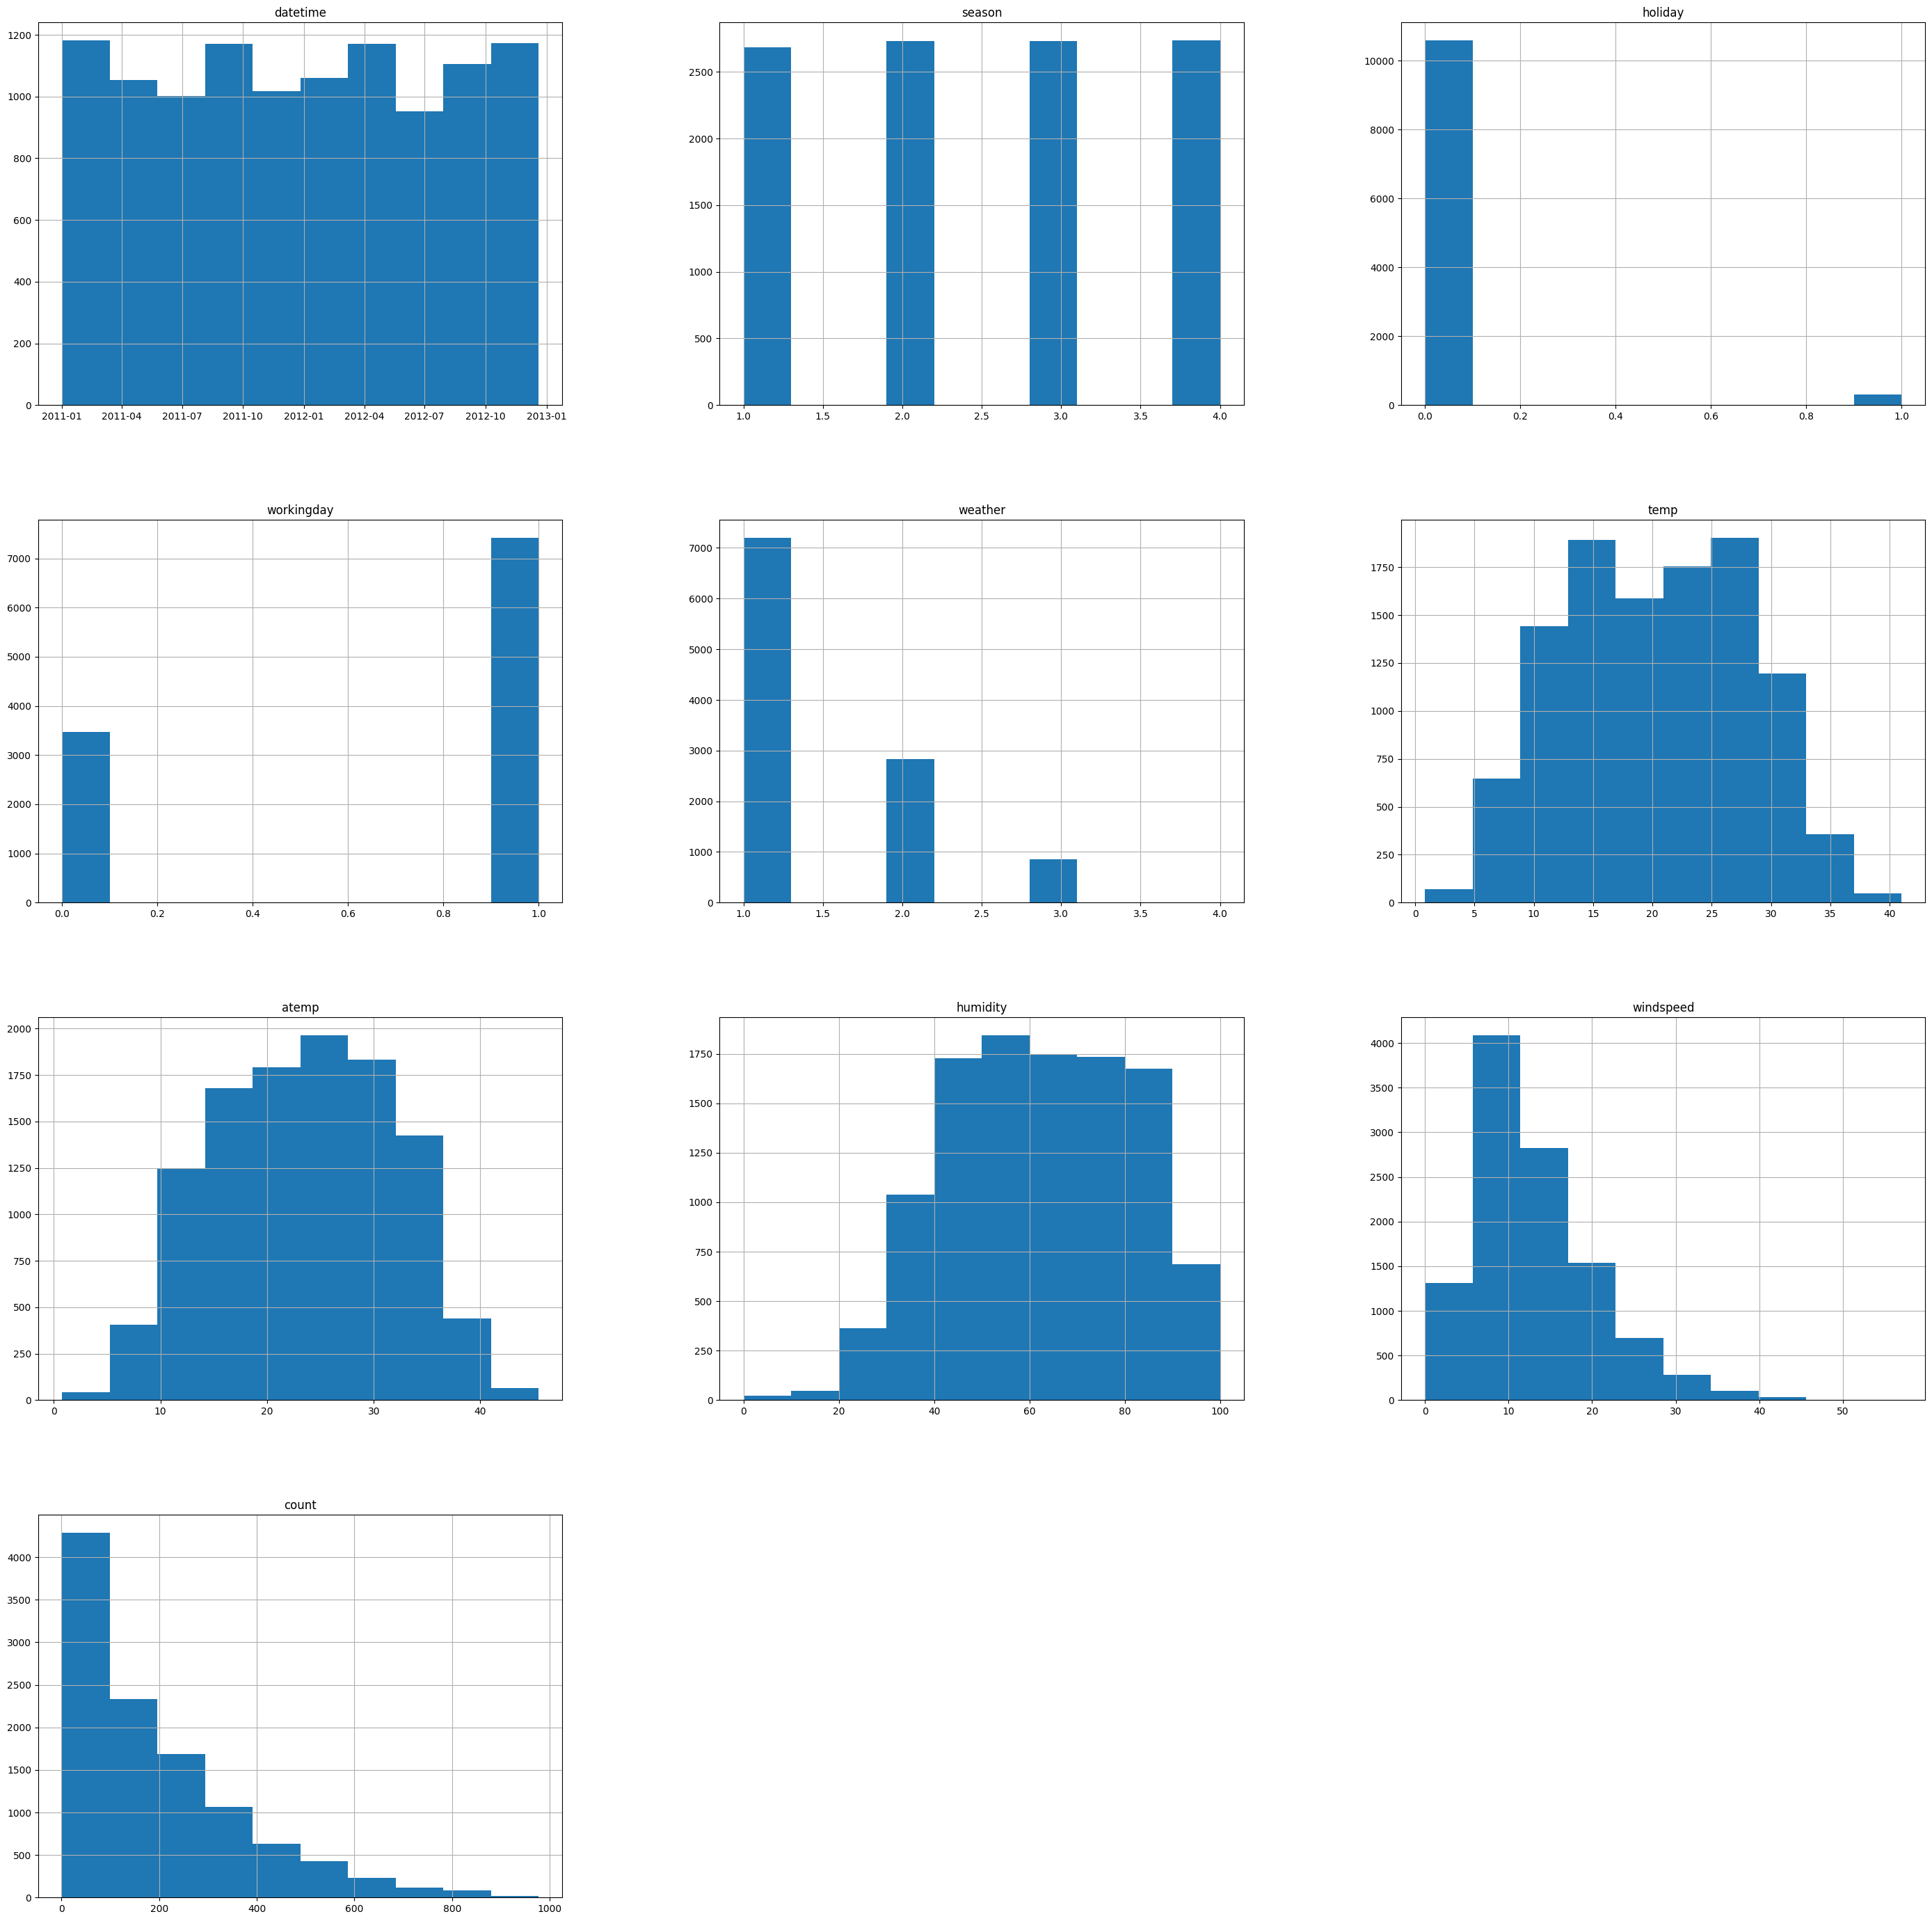

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=[35,35])

In [ ]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minutes'] = train['datetime'].dt.minute
train['seconds'] = train['datetime'].dt.second
train


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minutes,seconds
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,0,0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,0,0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,0,0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,0,0


In [ ]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minutes'] = test['datetime'].dt.minute
test['seconds'] = test['datetime'].dt.second
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minutes,seconds
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19,0,0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20,0,0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21,0,0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22,0,0


**Make category types for these so models know they are not just numbers**


*   AutoGluon originally sees these as ints, but in reality they are int representations of a category.

*   Setting the dtype to category will classify these as categories in AutoGluon.



In [ ]:
train["season"] = train['season'].astype('category')
train["weather"] = train['weather'].astype('category')
test["season"] = test['season'].astype('category')
test["weather"] = test['weather'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
 10  year        10886 non-null  int32         
 11  month       10886 non-null  int32         
 12  day         10886 non-null  int32         
 13  hour        10886 non-null  int32         
 14  minutes     10886 non-null  int32         
 15  seconds     10886 non-null  int32         
dtypes: category(2), dateti

In [ ]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minutes,seconds
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,0,0


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'minutes'}>],
       [<Axes: title={'center': 'seconds'}>,
        <Axes: title={'center': 'day'}>, <Axes: >, <Axes: >]],
      dtype=object)

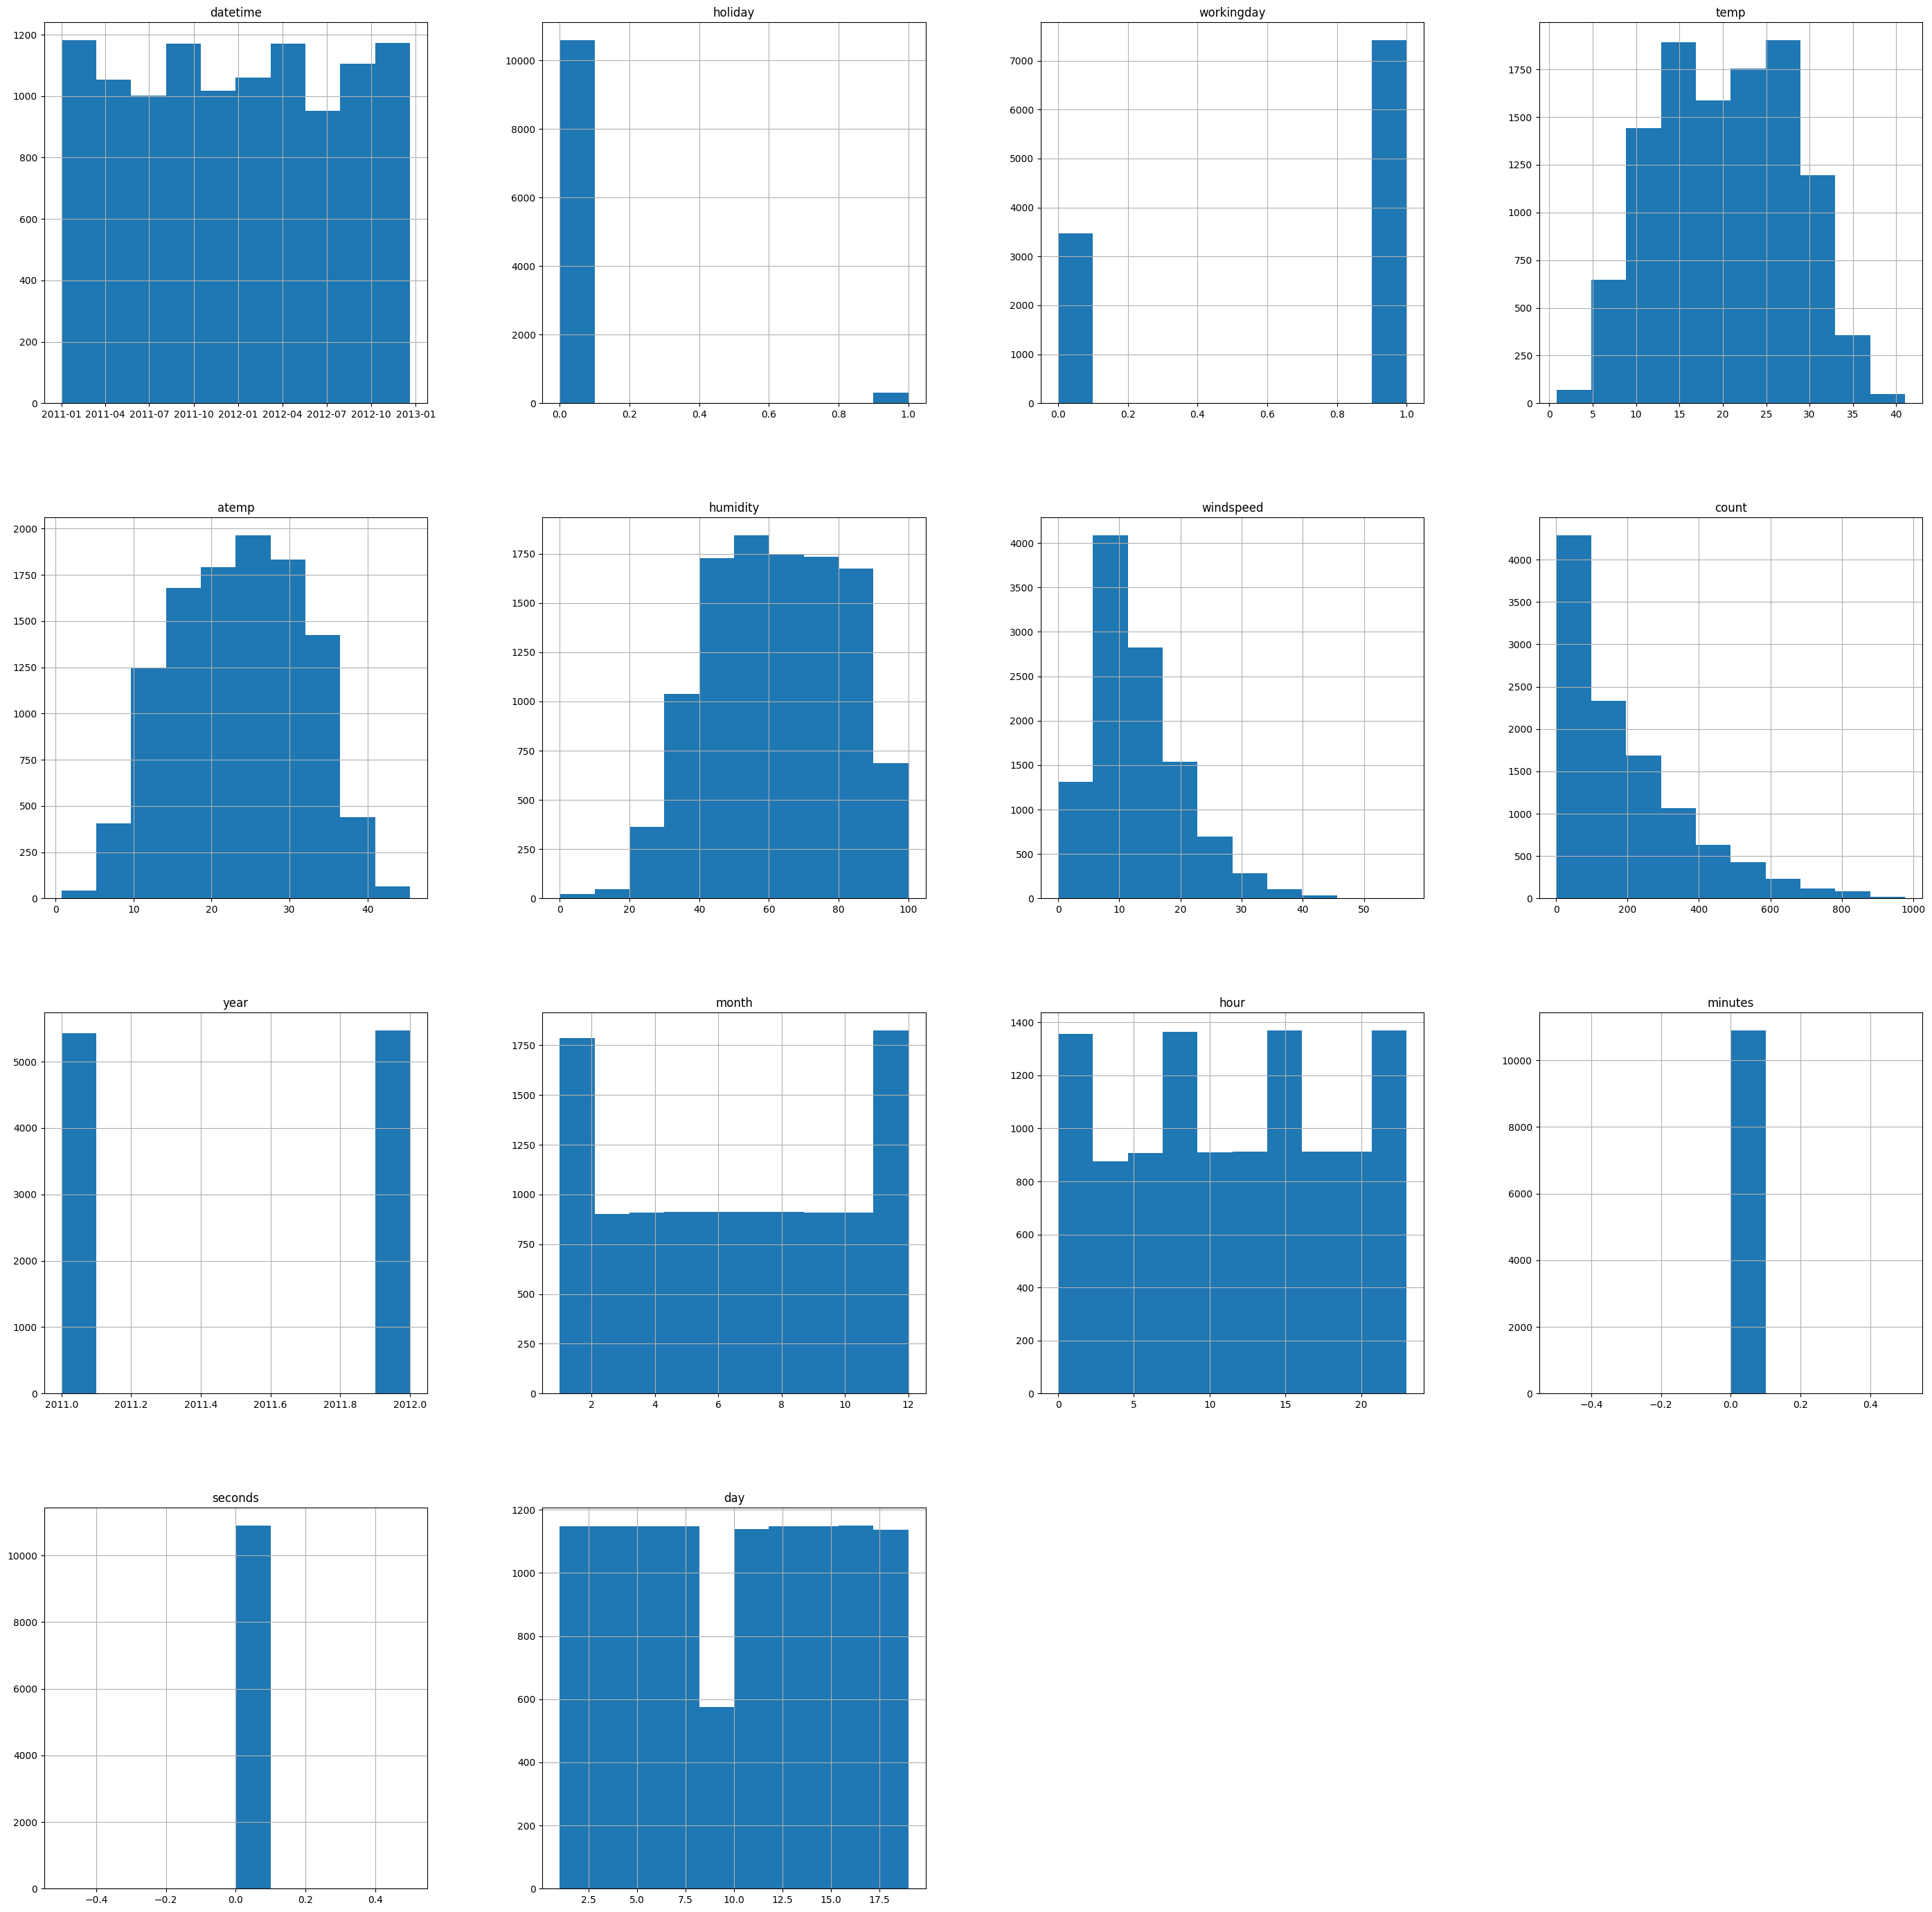

In [ ]:
# View histogram of all features again now with the hour feature
train.hist(figsize=[35,35])

**Step 5: Rerun the model with the same settings as before, just with more features**

In [ ]:
predictor_new_features = TabularPredictor(label='count',problem_type='regression',eval_metric='root_mean_squared_error').fit(train,time_limit=600,presets='best_quality')


No path specified. Models will be saved in: "AutogluonModels/ag-20240424_134959"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240424_134959/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 191 seconds

In [ ]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.537208  root_mean_squared_error      28.481895  379.287212                0.000896           0.040408            3       True         11
1          LightGBM_BAG_L2  -30.833354  root_mean_squared_error      26.192567  291.025988                0.488464          34.937361            2       True          9
2        LightGBMXT_BAG_L2  -31.283774  root_mean_squared_error      27.258896  297.388360                1.554793          41.299733            2       True          8
3   RandomForestMSE_BAG_L2  -31.842968  root_mean_squared_error      26.437742  303.009710                0.733639          46.921083            2       True         10
4      WeightedEnsemble_L2  -32.446450  root_mean_squared_error      25.603290  256.081158   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.65804730277418,
  'LightGBM_BAG_L1': -33.91733862651761,
  'RandomForestMSE_BAG_L1': -38.47013668628054,
  'CatBoost_BAG_L1': -37.41186724765934,
  'WeightedEnsemble_L2': -32.44645032136748,
  'LightGBMXT_BAG_L2': -31.28377435941289,
  'LightGBM_BAG_L2': -30.83335411

<Axes: xlabel='model'>

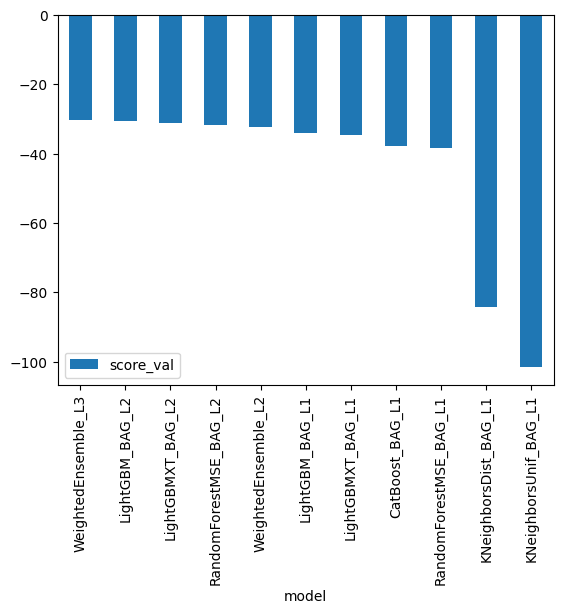

In [ ]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [ ]:
predictions_new_features = predictor_new_features.predict(test)

In [ ]:
predictions_new_features.describe()

count    6493.000000
mean      163.829361
std       146.188965
min         1.700780
25%        49.224644
50%       126.013306
75%       233.703827
max       813.281433
Name: count, dtype: float64

In [ ]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features<0] = 0

In [ ]:
# How many negative values do we have?
negative_count = predictions_new_features[predictions_new_features < 0 ].count()
print(f"The count of negative values: {negative_count}")

The count of negative values: 0


In [ ]:
submission_new_features = submission

In [ ]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:01<00:00, 168kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-24 14:06:35  new features                       complete  0.61256      0.61256       
submission_new_hpo.csv       2024-04-24 11:22:52  new features with hyperparameters  complete  1.80546      1.80546       
submission_new_features.csv  2024-04-24 08:05:09  new features                       complete  1.80546      1.80546       


New Score of 0.61256  

**Step 6: Hyper parameter optimization**


*  There are many options for hyper parameter optimization.


*   Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.



*   The hyperparameters of the models themselves that are in AutoGluon. Those need the hyperparameter and hyperparameter_tune_kwargs arguments.



**1. Using only the Random Forest model to train**

In [ ]:
predictor_new_hpo = TabularPredictor(label='count',problem_type='regression',eval_metric='root_mean_squared_error').fit(train,time_limit=600,presets='best_quality',hyperparameters={'RF': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}]})

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_141341"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240424_141341/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 64 seconds 

In [ ]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3 -38.316530  root_mean_squared_error       1.347723  51.895672                0.001476           0.024604            3       True          4
1  RandomForestMSE_BAG_L1 -38.424984  root_mean_squared_error       0.644475  21.320060                0.644475          21.320060            1       True          1
2     WeightedEnsemble_L2 -38.424984  root_mean_squared_error       0.645478  21.325762                0.001003           0.005702            2       True          2
3  RandomForestMSE_BAG_L2 -39.600063  root_mean_squared_error       1.346247  51.871068                0.701771          30.551008            2       True          3
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_RF', 'WeightedEnsembleModel'}
Ba

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'RandomForestMSE_BAG_L1': -38.424983594881716,
  'WeightedEnsemble_L2': -38.424983594881716,
  'RandomForestMSE_BAG_L2': -39.60006295824643,
  'WeightedEnsemble_L3': -38.316530263160494},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'RandomForestMSE_BAG_L1': ['RandomForestMSE_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'RandomForestMSE_BAG_L2': ['RandomForestMSE_BAG_L2'],
  'WeightedEnsemble_L3': ['WeightedEnsemble_L3']},
 'model_fit_times': {'RandomForestMSE_BAG_L1': 21.320059537887573,
  'WeightedEnsemble_L2': 0.005702495574951172,
  'RandomForestMSE_BAG_L2': 30.551008224487305,
  'WeightedEnsemble_L3': 0.024604320526123047},
 'model_pred_times': {'RandomForestMSE_BAG_L1': 0.6444754600524902,
  'WeightedEnsemble

<Axes: xlabel='model'>

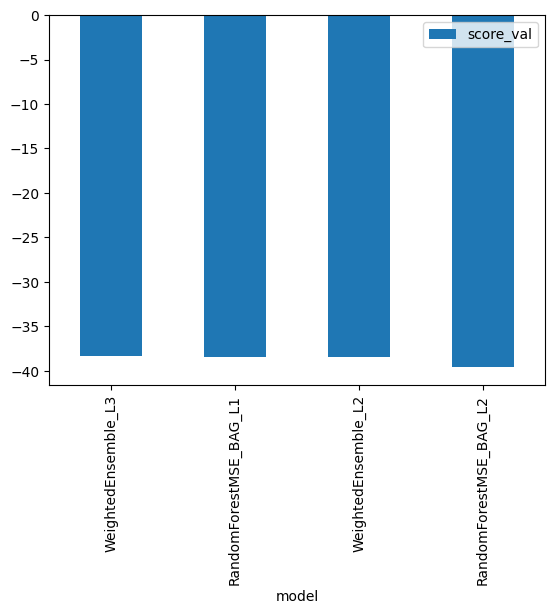

In [ ]:
predictor_new_hpo.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [ ]:
predictions_hpo = predictor_new_hpo.predict(test)

In [ ]:
predictions_hpo.describe()

count    6493.000000
mean      195.478165
std       174.022781
min         2.273333
25%        51.370003
50%       154.941483
75%       284.403351
max       894.465576
Name: count, dtype: float64

**2. Changing the hyperparameter value to 'light**

In [ ]:
predictor_new_hpo2 = TabularPredictor(label='count',problem_type='regression',eval_metric='root_mean_squared_error').fit(train,time_limit=600,presets='best_quality',hyperparameters='light')

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_142029"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240424_142029/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 238 seconds

In [ ]:
predictor_new_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3 -32.494985  root_mean_squared_error      34.770496  289.838005                0.001333           0.076150            3       True          7
1     WeightedEnsemble_L2 -32.740739  root_mean_squared_error      34.058057  229.933192                0.000970           0.016220            2       True          3
2         LightGBM_BAG_L2 -33.160354  root_mean_squared_error      34.226752  264.308725                0.169665          34.391753            2       True          5
3  RandomForestMSE_BAG_L2 -33.269958  root_mean_squared_error      34.599499  255.370103                0.542412          25.453131            2       True          6
4         LightGBM_BAG_L1 -33.917339  root_mean_squared_error       4.708563   65.471541               

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': -34.453884062670745,
  'LightGBM_BAG_L1': -33.91733862651761,
  'WeightedEnsemble_L2': -32.740738835931275,
  'LightGBMXT_BAG_L2': -34.13293985791951,
  'LightGBM_BAG_L2': -33.16035361728318,
  'RandomForestMSE_BAG_L2': -33.2699578734957,
  'WeightedEnsemble_L3': -32.4949851200591},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBMXT_BAG_L1': ['LightGBMXT_BAG_L1'],
  'LightGBM_BAG_L1': ['LightGBM_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'LightGBMXT_BAG_L2': ['LightGBMXT_BAG_L2'],
  'LightGBM_BAG_L2': ['LightGBM_BAG_L2'],
  'RandomForestMSE_BAG

<Axes: xlabel='model'>

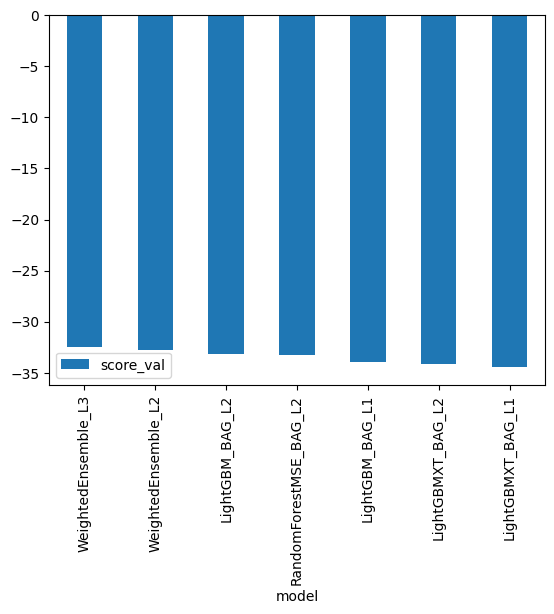

In [ ]:
predictor_new_hpo2.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [ ]:
predictions_hpo2 = predictor_new_hpo2.predict(test)

In [ ]:
predictions_hpo2.describe()

count    6493.000000
mean      190.808517
std       173.442307
min       -10.797377
25%        46.030205
50%       148.694672
75%       281.971527
max       901.421021
Name: count, dtype: float64

In [ ]:
predictions_hpo2[predictions_hpo2 < 0] = 0

In [ ]:
predictor_new_features_hpo3 = TabularPredictor(label='count',problem_type='regression',eval_metric='root_mean_squared_error').fit(train,time_limit=1800,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240424_181520"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1800 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240424_181520/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 510 second

In [ ]:
predictor_new_features_hpo3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.213475  root_mean_squared_error      53.232875  1255.055053                0.001367           0.078007            3       True         16
1          CatBoost_BAG_L2  -30.501320  root_mean_squared_error      48.423670  1028.414656                0.118362         167.714424            2       True         13
2          LightGBM_BAG_L2  -30.668274  root_mean_squared_error      49.038244   903.851279                0.732937          43.151047            2       True         11
3        LightGBMXT_BAG_L2  -31.307306  root_mean_squared_error      49.966059   907.449579                1.660752          46.749347            2       True         10
4     ExtraTreesMSE_BAG_L2  -31.551318  root_mean_squared_error      49.176875   877.458

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602

<Axes: xlabel='model'>

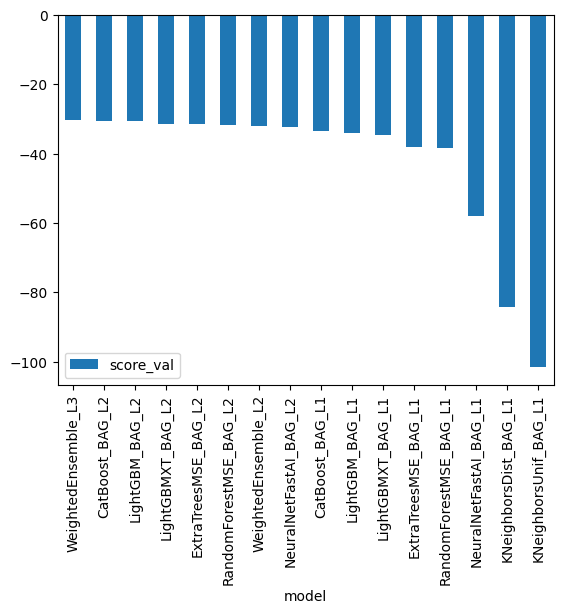

In [ ]:
predictor_new_features_hpo3.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val')

In [ ]:
predictions_hpo3 = predictor_new_features_hpo3.predict(test)

In [ ]:
predictions_hpo3.describe()

count    6493.000000
mean      156.467880
std       135.597443
min         1.618347
25%        53.584476
50%       119.913506
75%       225.271317
max       815.568604
Name: count, dtype: float64

In [ ]:
negative = predictions_hpo3[predictions_hpo3<0].count()
print(f"There are {negative} number negatives")

There are 0 number negatives


In [ ]:
predictions_hpo3[predictions_hpo3<0] = 0

In [ ]:
submission_new_hpo = submission

In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_hpo3
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 287kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-24 18:51:26  new features with hyperparameters  complete  0.67364      0.67364       
submission_new_hpo.csv       2024-04-24 15:43:40  new features with hyperparameters  complete  0.76276      0.76276       
submission_new_hpo.csv       2024-04-24 15:42:34  new features with hyperparameters  complete  0.50586      0.50586       




1.   New score for  hyperparameter optimization (changing model) 0.48509
2.   New score for  hyperparameter optimization (changing to light) 0.50586
3.   New score for  hyperparameter optimization (changing time_limit )  0.76276



**Step 7: Write a Report
Refer to the markdown file for the full report
Creating plots and table for report**

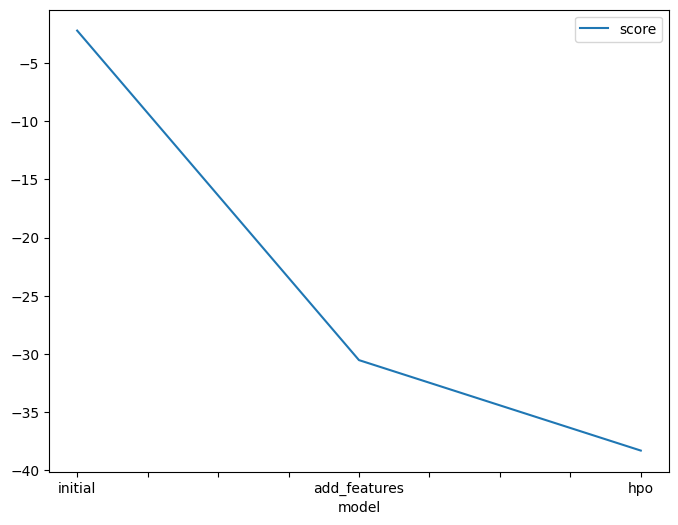

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-2.200765,-30.537208  , -38.316530]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

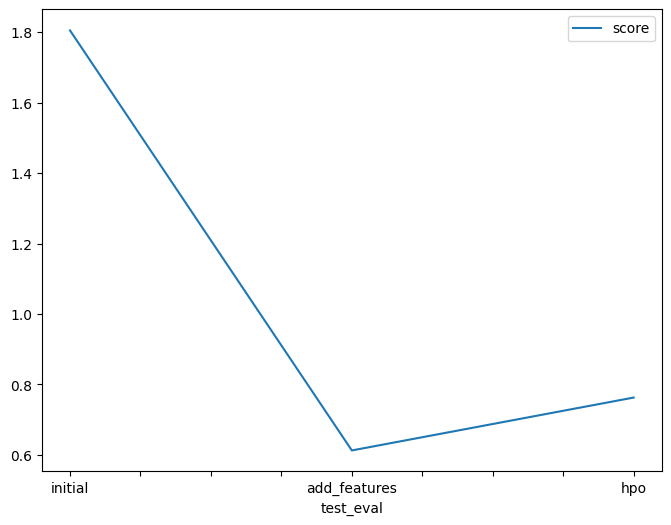

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80546, 0.61256, 0.76276]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

**Hyperparameter table**

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["time_limit", "time_limit", "Model hyperparameter"],
    "hpo2": ["presets", "presets", "light"],
    "hpo3": ["None", "None", "time_limit"],
    "score": [1.80546, 0.61256, 0.76276]
})

,model,hpo1,hpo2,hpo3,score
0,initial,time_limit,presets,None,1.80546
1,add_features,time_limit,presets,None,0.61256
2,hpo,Model hyperparameter,light,time_limit,0.76276
